# 1. Problem Statement

We need to model a NN that can predict hand written digits. 

We are using MNIST dataset for training and evaluating the model.

# 2. Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow_datasets as tfds

import tensorflow as tf

## 3. Getting Dataset

Using tensorflow_datasets to import the MNIST dataset.

In [2]:
[ds_train, ds_test], info = tfds.load("mnist",
                                      split = ['train', 'test'],
                                      shuffle_files = True,
                                      with_info = True,
                                      as_supervised = True)

print(ds_train, '\n')
print(ds_test)

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)> 

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


___
tfds.load(name, split, shuffle_files, with_info, as_supervised)

split --> which split to read. (refer info variable below)

shuffle_files --> control whether to shuffle the files between each epoch (TFDS store big datasets in multiple smaller files).

as_supervised --> True, loads the data in a 2 - tuple structure. [ input, target ]

with_info = True, provides a tuple containing info about version, features, # samples of the dataset

___

In [3]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

## 4. Preprocessing the data

### Getting the number of validation set and test set
___
tf.cast(x, dtype) --> casts (converts) a variable into a given datatype.
and changing it to the format of tensor.

___

In [4]:
num_validation_samples = 0.1 * info.splits['train'].num_examples
print(num_validation_samples)
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

num_test_samples = info.splits['test'].num_examples
print(num_test_samples,'\n')
num_test_samples = tf.cast(num_test_samples, tf.int64)

print(num_validation_samples,'\n')
print(num_test_samples)

6000.0
10000 

tf.Tensor(6000, shape=(), dtype=int64) 

tf.Tensor(10000, shape=(), dtype=int64)


### Scaling the dataset

In [5]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.
    return image, label

# using the map function and user defined scale function to scale the datasets.
scaled_train_and_validation_data = ds_train.map(scale)

test_data = ds_test.map(scale)

dataset.map(**function**) --> applies a custom transformation to a given dataset. It takes an input a function which determines the transformation.
___

### Shuffling| seperating cross validation set and test set.

Using shuffling to make the data as random as possible. 

___

shuffle(buffer_size)--> This dataset fills a buffer with `buffer_size` elements, then randomly
samples elements from this buffer, replacing the selected elements with new
elements.

___
if buffer_size = 1; no shuffling will actually happen.

if buffer_size >= num_samples; shuffling will happen at once (uniformly)

if 1< buffer_size < num_samples; we will be optimizng the computational power.

___

In [6]:
# shuffling
BUFFER_SIZE = 10000
shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)
# notice how we are randomizing only the training set.

# seperating cv and train set.
validation_data = shuffled_train_and_validation_data.take(num_validation_samples)

train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

In [7]:
print(train_data,'\n')
print(validation_data,'\n')
print(test_data)

<SkipDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)> 

<TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)> 

<MapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>


### Creating batches

method `.batch()` adds new column to our tensor indicating how many sample it should take in each batch.

___
we only use batch as a technique to increase the training speed.
<br>So, training needs batch.

Does cv also needs it? No, as its already trained.

But, the model expects all our inputs as same dimension thus cv requires the column for batch size and so does test.

___

In [8]:
BATCH_SIZE = 100

train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples)

test_data = test_data.batch(num_test_samples)

# iter() creates an object which can be iterated one element at a time.
# eg: in a for loop or while loop
validation_inputs, validation_targets = next(iter(validation_data))

In [9]:
print(train_data,'\n')
print(validation_data,'\n')
print(test_data)

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)> 

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)> 

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


In [10]:
print('tf.Tensor:',validation_inputs.shape,'\n')
print('tf.Tensor:',validation_targets.shape,)

tf.Tensor: (6000, 28, 28, 1) 

tf.Tensor: (6000,)


## 5. Model

In [11]:
inputs_size = 784
output_size = 10

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (3,3),activation = 'relu', input_shape = (28, 28, 1)),    
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dense(output_size, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 40)                54120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                410       
Total params: 54,610
Trainable params: 54,610
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'],
             )

In [13]:
num_epochs = 100

model.fit(train_data, epochs = num_epochs,
         validation_data = (validation_inputs, validation_targets),
         verbose = 2,
          callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
         )

Epoch 1/100
540/540 - 6s - loss: 0.3729 - accuracy: 0.8944 - val_loss: 0.1938 - val_accuracy: 0.9460
Epoch 2/100
540/540 - 6s - loss: 0.1368 - accuracy: 0.9607 - val_loss: 0.1241 - val_accuracy: 0.9647
Epoch 3/100
540/540 - 6s - loss: 0.0960 - accuracy: 0.9719 - val_loss: 0.1099 - val_accuracy: 0.9693
Epoch 4/100
540/540 - 6s - loss: 0.0776 - accuracy: 0.9769 - val_loss: 0.0821 - val_accuracy: 0.9765
Epoch 5/100
540/540 - 6s - loss: 0.0647 - accuracy: 0.9807 - val_loss: 0.0712 - val_accuracy: 0.9795
Epoch 6/100
540/540 - 6s - loss: 0.0544 - accuracy: 0.9839 - val_loss: 0.0724 - val_accuracy: 0.9785
Epoch 7/100
540/540 - 6s - loss: 0.0478 - accuracy: 0.9861 - val_loss: 0.0635 - val_accuracy: 0.9828
Epoch 8/100
540/540 - 6s - loss: 0.0428 - accuracy: 0.9874 - val_loss: 0.0519 - val_accuracy: 0.9863
Epoch 9/100
540/540 - 6s - loss: 0.0380 - accuracy: 0.9892 - val_loss: 0.0474 - val_accuracy: 0.9863
Epoch 10/100
540/540 - 6s - loss: 0.0326 - accuracy: 0.9901 - val_loss: 0.0488 - val_accura

___
**(0.9* 60000)/100 = 540** batches per epoch.

___

### Check for overfitting

As long as reg line(train_cost) is above blue (cv_cost) at the end, the model is not overfitting.

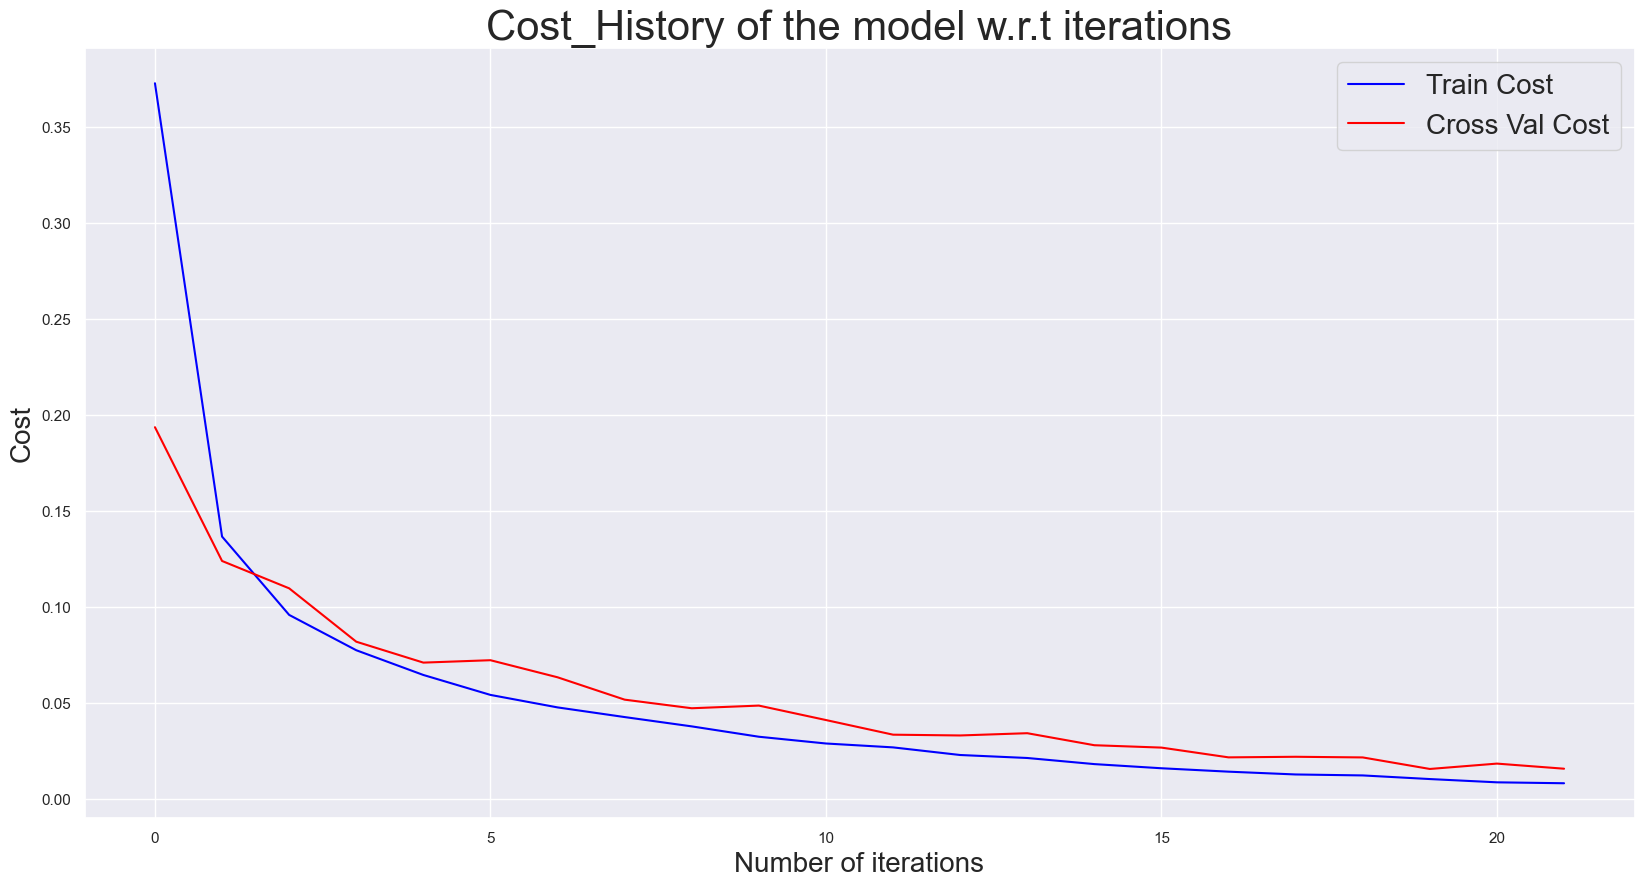

In [14]:
fig, ax = plt.subplots(figsize = (20,10))
ax = plt.plot(model.history.history['loss'], color = 'Blue')
ax = plt.plot(model.history.history['val_loss'], color = 'red')
plt.title('Cost_History of the model w.r.t iterations', fontsize = 30)
plt.xlabel('Number of iterations', fontsize = 20)
plt.ylabel('Cost', fontsize = 20)
plt.legend(['Train Cost', 'Cross Val Cost'], fontsize = 20)
plt.show()

# 6. Testing using test data

In [15]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 0s 11ms/step - loss: 0.0611 - accuracy: 0.9836


In [16]:
print(f'Test loss:{round(test_loss, 3)}. Test accuracy:{round(test_accuracy, 3)}')

Test loss:0.061. Test accuracy:0.984
